In [33]:
%run main.py
%run modeling.py
%run EDAmain.py

# İçindekiler

#### 1- Configurations
#### 2- Data Preparation
###### 2.1- Prepare Train/Test dataset
###### 2.2- Encoding & Scaling
#### 3- Modeling
###### 3.1 Utility Functions
###### 3.2 CatBoost
###### 3.3 XGBoost
###### 3.4 LGBM
###### 3.5 Stacking Ensemble
#### 4- Load Model

In [34]:
df = pd.read_csv("D:\SERKAN KIZILIRMAK\Python\AllProjects\Müşteri Kayıp Analizi (TelcoCustomer)\Data\TelcoCustomer(TR)_binned.csv")

In [35]:
df["Kayıp Durumu"].head()

0    Yok
1    Yok
2    Var
3    Yok
4    Var
Name: Kayıp Durumu, dtype: object

In [36]:
df["Kayıp Durumu"]=[1 if kod=="Var" else 0 for kod in df["Kayıp Durumu"]]

# Configurations

In [37]:
# seed value
SEED = 42

# set optuna verbosity level
# default 20
# optuna_verbosity = optuna.logging.WARNING # https://optuna.readthedocs.io/en/latest/reference/logging.html#module-optuna.logging

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

# Data Preparation

### 2.1 Prepare Train/Test dataset

In [38]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_index, test_index in strat_split.split(df, df["Kayıp Durumu"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

print('Target Labels Ratio in Original Dataset\n')
print(df["Kayıp Durumu"].value_counts(normalize=True).sort_index())
# df_churn_cleaned["Churn"].value_counts() / len(strat_test_set)

print('\nTarget Labels Ratio in Test Dataset\n')
print(strat_test_set["Kayıp Durumu"].value_counts(normalize=True).sort_index())
# strat_test_set["Churn"].value_counts() / len(strat_test_set)

Target Labels Ratio in Original Dataset

0    0.73463
1    0.26537
Name: Kayıp Durumu, dtype: float64

Target Labels Ratio in Test Dataset

0    0.734564
1    0.265436
Name: Kayıp Durumu, dtype: float64


In [39]:
# train Dataset
X = strat_train_set.drop("Kayıp Durumu", axis=1)
y = strat_train_set["Kayıp Durumu"].copy()

# test dataset
y_test = strat_test_set['Kayıp Durumu'].values
X_test = strat_test_set.drop('Kayıp Durumu',axis=1)

X.shape, y.shape, X_test.shape, y_test.shape

((5634, 22), (5634,), (1409, 22), (1409,))

In [40]:
# Check cardinality of categorical variables :

# reinitiate cat_cols because 'customerID' is still included in cat_cols variable
cat_cols = list(set(X.columns) - set(X._get_numeric_data().columns))
num_cols = list(set(X._get_numeric_data().columns) - set({'65 Yaş Üstü'})) # already converted
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X[col].nunique(), cat_cols))
d = dict(zip(cat_cols, object_nunique))

print("Number of unique entries by column, in ascending order:\n")

sorted_cols_by_cardinality = sorted(d.items(), key=lambda x: x[1])
display(pd.DataFrame(sorted_cols_by_cardinality, columns=['Columns', 'Cardinality']))

print("Total Categorical Columns",len(cat_cols))
print("Total Numerical Columns",len(num_cols))

printmd("**<br>Dataset has maximum cardinality value of 4 which is comparatively low<br>**")

Number of unique entries by column, in ascending order:



,Columns,Cardinality
0,Online Fatura(Kağıtsız),2
1,Medeni Durum,2
2,Bakma Sorumluluğu,2
3,Cinsiyet,2
4,Ev Telefonu Aboneliği,2
5,Güvenlik Hizmeti Aboneliği,3
6,Yedekleme Hizmeti Aboneliği,3
7,Aylık Ücret-binned,3
8,Sözleşme Süresi,3
9,Birden Fazla Abonelik Durumu,3


Total Categorical Columns 18
Total Numerical Columns 3


**<br>Dataset has maximum cardinality value of 4 which is comparatively low<br>**

# 2.2 Encoding & Scaling

In [41]:
ordinal_encoder = OrdinalEncoder()
X[cat_cols] = ordinal_encoder.fit_transform(X[cat_cols])
X_test[cat_cols] = ordinal_encoder.transform(X_test[cat_cols])

le = LabelEncoder()
y = le.fit_transform(y)

y_test = le.fit_transform(y_test)


num_cols = ['Müşteri Olma Süresi(Ay)', 'Aylık Ücret', 'Toplam Ücret']

transformer = RobustScaler()
X[num_cols] = transformer.fit_transform(X[num_cols])
X_test[num_cols] = transformer.transform(X_test[num_cols])

Correlation Heatmap
Pearson’s R (parametric) is not applicable when the data is categorical

Kendall’s Tau is a non-parametric measure of relationships between continuous or ordinal features

While Pearson's correlation assesses linear relationships, Spearman's correlation (non -parametric) assesses monotonic relationships (whether linear or not)

Most of the features in this dataset are categorical and nominal, so it's ineffective for those non-numerical attributes

Moreover, there are only three numerical features which are not normally distributed

Therefore, pandas.corr() is not feasible to use for this case

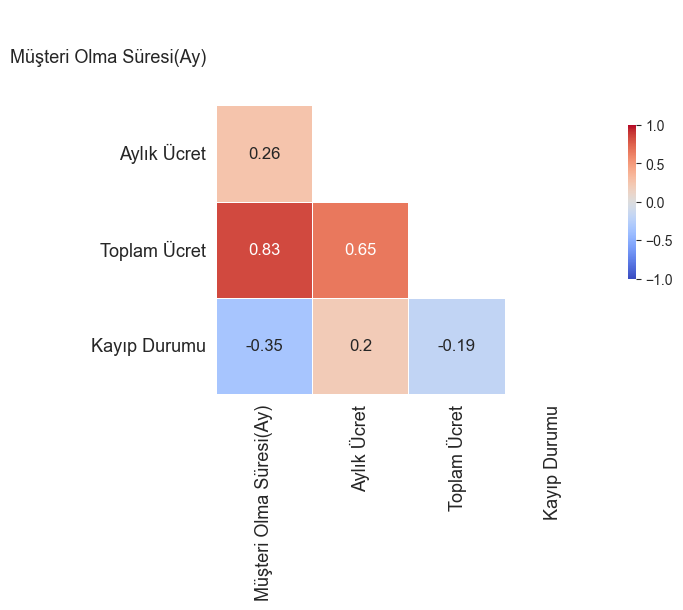

**Tenure is moderately correlated Numerical Feature with Target**

In [42]:
# Correlation Matrix
# only numerical output
corr_matrix = pd.concat([X[num_cols],strat_train_set[["Kayıp Durumu"]]],axis=1).corr() # 'spearman' / 'pearson' / 'kendall'

# Set Up Mask To Hide Upper Triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)]= True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0, fontsize=13)
ax.set_xticklabels(corr_matrix.columns, fontsize=13)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.show()

printmd("**Tenure is moderately correlated Numerical Feature with Target**")

# 3- Modeling